# Model-3: SiLU Activation, Batch Normalization and Inception Layers

- BatchNorm improves training stability and speeds up convergence
- SiLU activation allows better gradient propagation and reduces dead neurons
- Inception blocks allow multi-scale feature extraction

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets

In [2]:
try:
    from torchinfo import summary
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchinfo"])
    from torchinfo import summary

In [3]:
try:
    import torchmetrics
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchmetrics"])
    import torchmetrics

In [4]:
import os
repo_url = "https://raw.githubusercontent.com/vardanskamra/Deep-Multimedia-Steganography/main/utils"
files = [
    "__init__.py",
    "test.py",
    "train.py",
    "metrics.py",
    "transforms.py",
    "visualizations.py",
    "inference.py"
]
os.makedirs("utils", exist_ok=True)

for file in files:
    file_url = f"{repo_url}/{file}"
    os.system(f"curl -s {file_url} -o utils/{file}")

print("Downloaded all utils files successfully!")

Downloaded all utils files successfully!


In [5]:
import sys
sys.path.append("./utils") 

In [6]:
import utils

from utils.transforms import train_test_transform
from utils.metrics import loss_function
from utils.train import train
from utils.test import test

from utils.visualizations import plot_metrics
from utils.visualizations import visualize_images

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=train_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 169M/169M [00:01<00:00, 100MB/s]  


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")
print(f"Train DataLoader Length: {len(train_loader)}")
print(f"Test DataLoader Length: {len(test_loader)}")

sample, label = next(iter(train_loader))
print(f"Sample Shape: {sample.shape}")
print(f"Label Shape: {label.shape}")

Train Dataset Length: 50000
Test Dataset Length: 10000
Train DataLoader Length: 1563
Test DataLoader Length: 313
Sample Shape: torch.Size([32, 3, 128, 128])
Label Shape: torch.Size([32])


In [10]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1)
        )

        self.branch5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )

        self.bn = nn.BatchNorm2d(3 * out_channels)
        self.skip = nn.Conv2d(in_channels, 3 * out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.branch1(x)
        x3 = self.branch3(x)
        x5 = self.branch5(x)
        out = torch.cat([x1, x3, x5], dim=1)
        return nn.functional.silu(self.bn(out + self.skip(x)))  # SiLU activation + Skip connection

In [11]:
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()

        # 3x3 convolutions
        self.conv3_1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # 5x5 convolutions
        self.conv5_1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv5_2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.conv5_3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        
        # 4x4 convolutions
        self.conv7_1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3)
        self.conv7_2 = nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=3)
        self.conv7_3 = nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3)

        # BatchNorm layers
        self.bn3 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)
        self.bn7 = nn.BatchNorm2d(64)

        self.final_conv = nn.Conv2d(192, 3, kernel_size=3, stride=1, padding=1)
        self.final_bn = nn.BatchNorm2d(3)

    def forward(self, x):
        x3 = self.bn3(self.conv3_3(nn.functional.silu(self.conv3_2(nn.functional.silu(self.conv3_1(x))))))
        x5 = self.bn5(self.conv5_3(nn.functional.silu(self.conv5_2(nn.functional.silu(self.conv5_1(x))))))
        x7 = self.bn7(self.conv7_3(nn.functional.silu(self.conv7_2(nn.functional.silu(self.conv7_1(x))))))
        x = torch.cat([x3, x5, x7], dim=1)  # Concatenation
        x = self.final_bn(self.final_conv(x))
        return torch.sigmoid(x)  # Normalized output

In [12]:
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.inc1 = InceptionBlock(6, 32)   
        self.inc2 = InceptionBlock(96, 64)  
        self.inc3 = InceptionBlock(192, 128)  

        self.conv = nn.Conv2d(384, 3, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(3)

    def forward(self, cover, secret_prepared):
        x = torch.cat([cover, secret_prepared], dim=1)
        x = self.inc1(x)
        x = self.inc2(x)
        x = self.inc3(x)
        x = self.bn(self.conv(x))
        return torch.sigmoid(x)  # Stego image

In [13]:
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()

        self.decoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

    def forward(self, stego):
        return self.decoder(stego)  # Recovered secret image

In [14]:
print(f"Device: {device}")
prep_net = nn.DataParallel(PrepNetwork()).to(device)
hide_net = nn.DataParallel(HidingNetwork()).to(device)
reveal_net = nn.DataParallel(RevealNetwork()).to(device)

Device: cuda


In [15]:
print("PrepNetwork Summary:")
print(summary(prep_net, input_size=(32, 3, 128, 128)))

cover = torch.randn(32, 3, 128, 128)
secret_prepared = torch.randn(32, 3, 128, 128)

print("\nHidingNetwork Summary:")
print(summary(hide_net, input_data=[cover, secret_prepared])) # 6 channels (cover + secret_prepared)

print("\nRevealNetwork Summary:")
print(summary(reveal_net, input_size=(32, 3, 128, 128)))

PrepNetwork Summary:
Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [32, 3, 128, 128]         --
├─PrepNetwork: 1-1                       [16, 3, 128, 128]         222,377
├─PrepNetwork: 1-4                       --                        (recursive)
│    └─Conv2d: 2-1                       [16, 16, 128, 128]        448
├─PrepNetwork: 1-3                       [16, 3, 128, 128]         --
├─PrepNetwork: 1-4                       --                        (recursive)
│    └─Conv2d: 2-2                       [16, 16, 128, 128]        --
│    └─Conv2d: 2-3                       [16, 32, 128, 128]        --
│    └─Conv2d: 2-4                       [16, 32, 128, 128]        4,640
│    └─Conv2d: 2-5                       [16, 64, 128, 128]        18,496
│    └─Conv2d: 2-6                       [16, 64, 128, 128]        --
│    └─BatchNorm2d: 2-7                  [16, 64, 128, 128]        128
│    └─BatchNorm2d: 2-8         

In [16]:
optimizer = torch.optim.Adam(list(prep_net.parameters()) +
                       list(hide_net.parameters()) +
                       list(reveal_net.parameters()), lr=0.001)

In [ ]:
train_metrics = train(dataloader=train_loader,
                prep_net=prep_net,
                hide_net=hide_net,
                reveal_net=reveal_net,
                optimizer=optimizer,
                loss_fn=loss_function,
                beta=0.75,
                epochs=25,
                device=device)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/25], Loss: 0.0154, PSNR: 22.5611, SSIM: 0.9004, NC: 0.9147, Pixel Loss (Cover-Stego): 0.0601, Pixel Loss (Secret-Revealed): 0.0816
Epoch [2/25], Loss: 0.0119, PSNR: 22.8345, SSIM: 0.9151, NC: 0.9421, Pixel Loss (Cover-Stego): 0.0576, Pixel Loss (Secret-Revealed): 0.0685
Epoch [3/25], Loss: 0.0104, PSNR: 22.8919, SSIM: 0.9156, NC: 0.9540, Pixel Loss (Cover-Stego): 0.0569, Pixel Loss (Secret-Revealed): 0.0611
Epoch [4/25], Loss: 0.0097, PSNR: 23.1120, SSIM: 0.9173, NC: 0.9588, Pixel Loss (Cover-Stego): 0.0552, Pixel Loss (Secret-Revealed): 0.0580
Epoch [5/25], Loss: 0.0092, PSNR: 23.2398, SSIM: 0.9174, NC: 0.9609, Pixel Loss (Cover-Stego): 0.0543, Pixel Loss (Secret-Revealed): 0.0561
Epoch [6/25], Loss: 0.0088, PSNR: 23.4570, SSIM: 0.9178, NC: 0.9632, Pixel Loss (Cover-Stego): 0.0527, Pixel Loss (Secret-Revealed): 0.0547
Epoch [7/25], Loss: 0.0085, PSNR: 23.5990, SSIM: 0.9142, NC: 0.9646, Pixel Loss (Cover-Stego): 0.0518, Pixel Loss (Secret-Revealed): 0.0537
Epoch [8/25], Loss: 

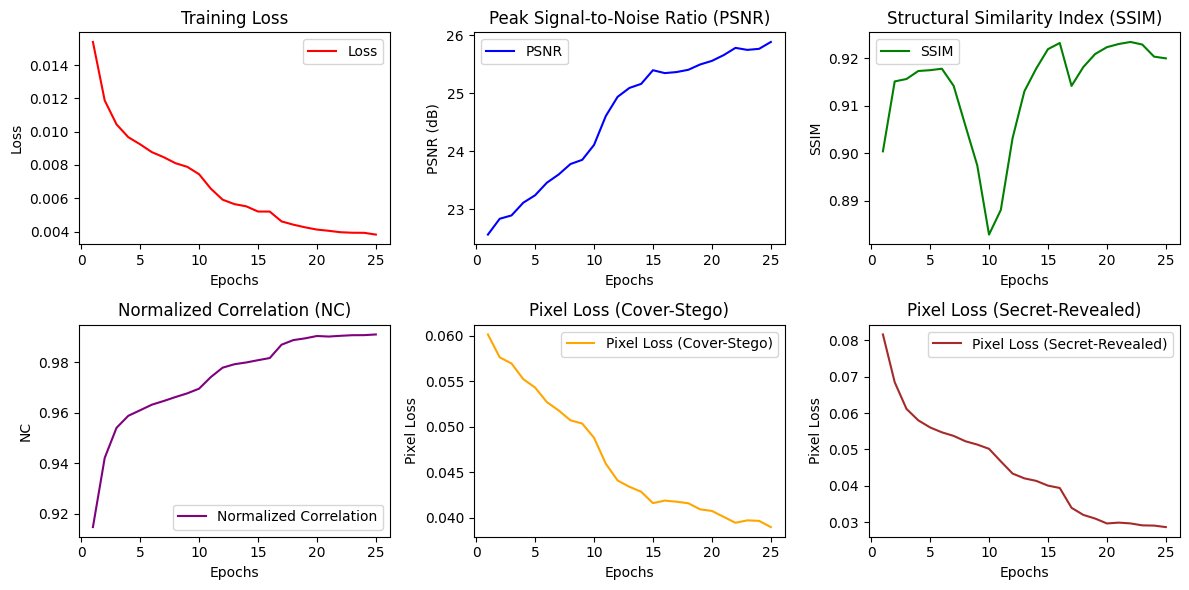


Final Evaluation Metrics:
Final Loss: 0.0038
Final PSNR: 25.8874 dB
Final SSIM: 0.9199
Final Normalized Correlation (NC): 0.9909
Final Pixel Loss (Cover-Stego): 0.0390
Final Pixel Loss (Secret-Revealed): 0.0286



In [22]:
plot_metrics(train_metrics)

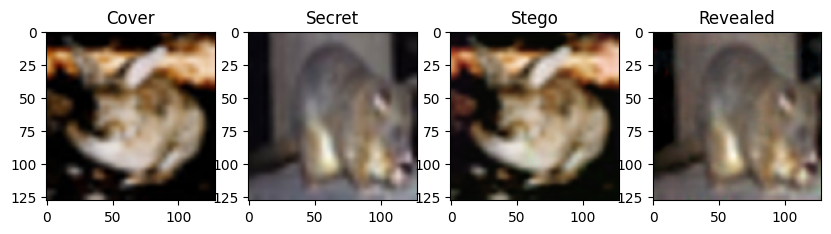

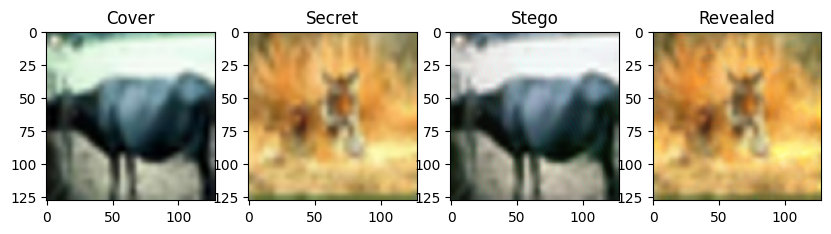

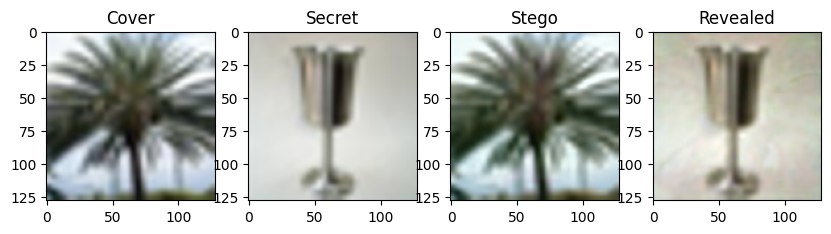

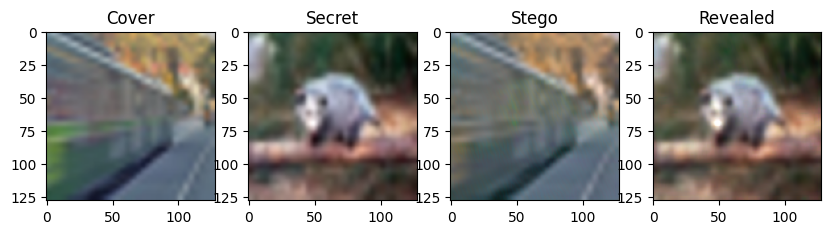

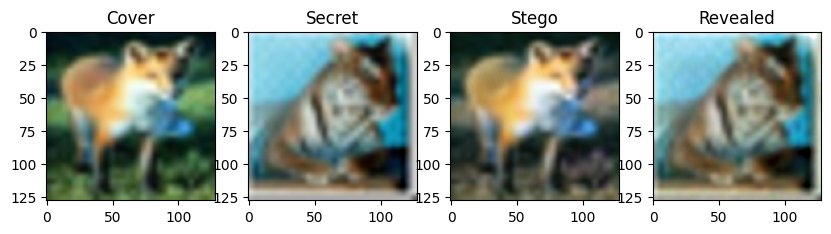

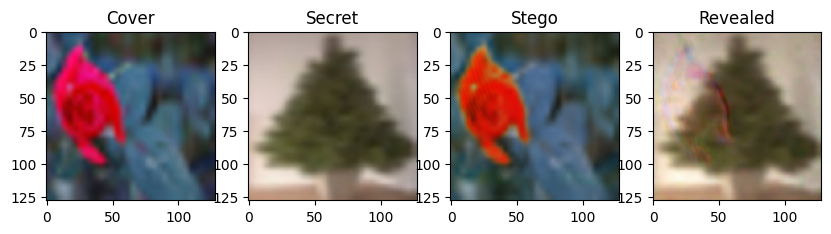

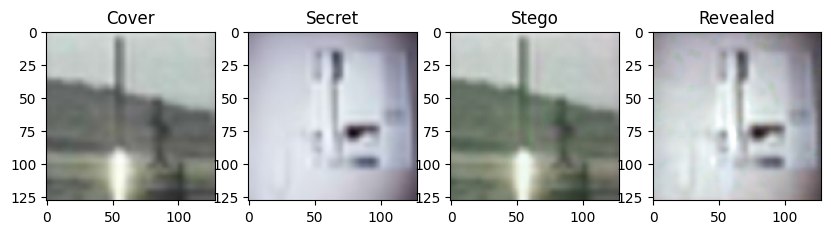

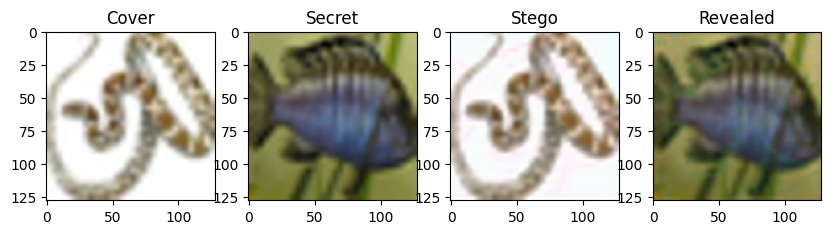

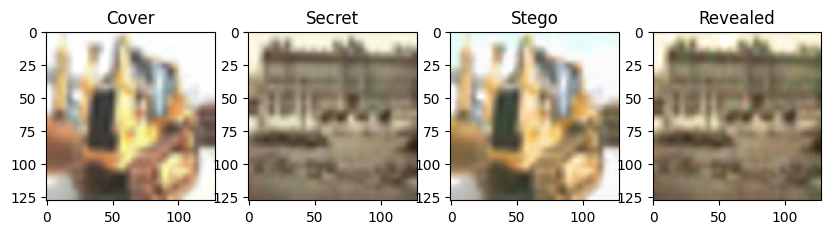

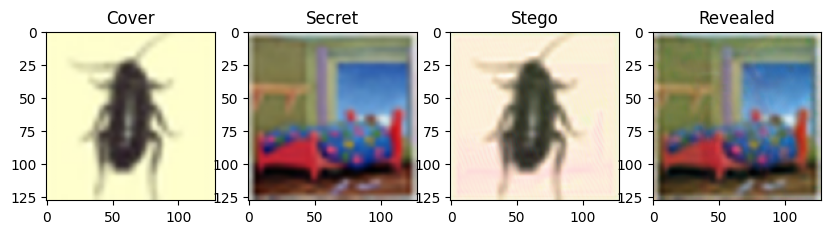

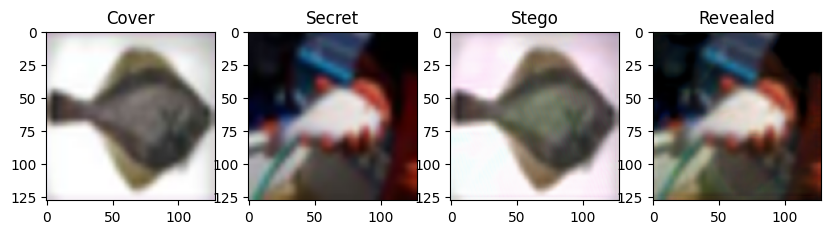

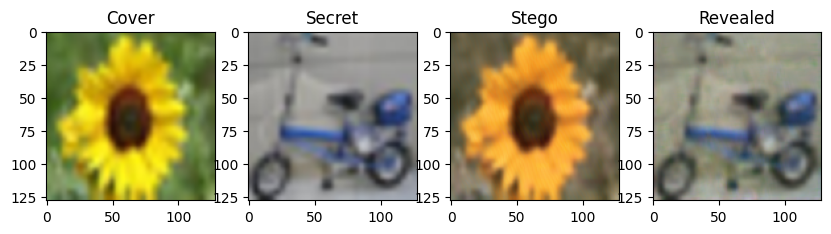

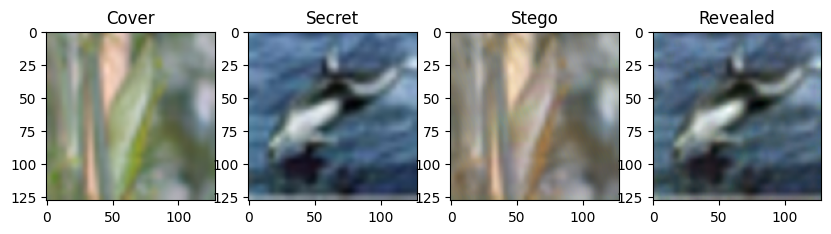

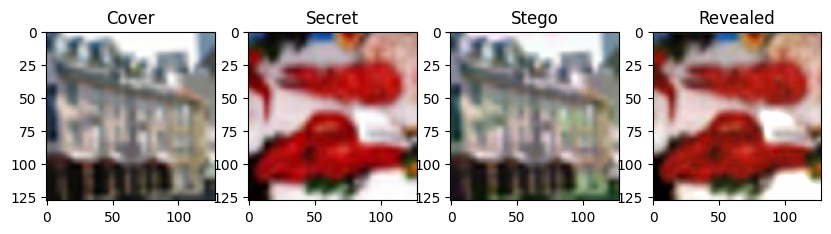

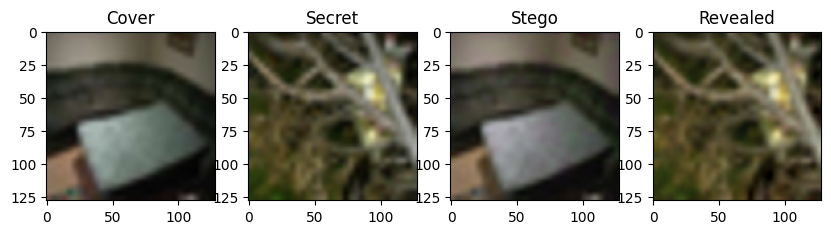


Test Results: Loss: 0.0024, PSNR: 27.9090, SSIM: 0.9286, NC: 0.9935, Pixel Loss (Cover-Stego): 0.0281, Pixel Loss (Secret-Revealed): 0.0237



In [23]:
test_metrics = test(prep_net=prep_net,
               hide_net=hide_net,
               reveal_net=reveal_net,
               dataloader=test_loader,
               loss_fn = loss_function,
               beta = 0.75,
               visualize = True,
               device=device)

In [24]:
checkpoint = {
    'epoch': 25, # New training stars from epoch 25, we've done 0-24
    'prep_net_state_dict': prep_net.module.state_dict(),
    'hide_net_state_dict': hide_net.module.state_dict(),
    'reveal_net_state_dict': reveal_net.module.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}

torch.save(checkpoint, "model_checkpoint.pth")

In [25]:
torch.save(prep_net.state_dict(), "/kaggle/working/prep_net.pth")
torch.save(hide_net.state_dict(), "/kaggle/working/hide_net.pth")
torch.save(reveal_net.state_dict(), "/kaggle/working/reveal_net.pth")